![image](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/notebooks/headers/watsonx-Prompt_Lab-Notebook.png)
# Agents Lab Notebook v1.0.0
This notebook contains steps and code to demonstrate the use of agents
configured in Agent Lab in watsonx.ai. It introduces Python API commands
for authentication using API key and invoking a LangGraph agent with a watsonx chat model.

**Note:** Notebook code generated using Agent Lab will execute successfully.
If code is modified or reordered, there is no guarantee it will successfully execute.
For details, see: <a href="/docs/content/wsj/analyze-data/fm-prompt-save.html?context=wx" target="_blank">Saving your work in Agent Lab as a notebook.</a>

Some familiarity with Python is helpful. This notebook uses Python 3.11.

## Notebook goals
The learning goals of this notebook are:

* Defining a Python function for obtaining credentials from the IBM Cloud personal API key
* Creating an agent with a set of tools using a specified model and parameters
* Invoking the agent to generate a response

# Setup

In [51]:
!pip install langchain-ibm ibm-watsonx-ai langchain-core langgraph requests
# import dependencies
from langchain_ibm import ChatWatsonx
from ibm_watsonx_ai import APIClient
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from ibm_watsonx_ai.foundation_models.utils import Tool, Toolkit
import json
import requests

## watsonx API connection
This cell defines the credentials required to work with watsonx API for Foundation
Model inferencing.

**Action:** Provide the IBM Cloud personal API key. For details, see
<a href="https://cloud.ibm.com/docs/account?topic=account-userapikey&interface=ui" target="_blank">documentation</a>.


In [52]:
import os
import getpass

def get_credentials():
	return {
		"url" : "https://us-south.ml.cloud.ibm.com",
		"apikey" : getpass.getpass("Please enter your api key (hit enter): ")
	}

def get_bearer_token():
    url = "https://iam.cloud.ibm.com/identity/token"
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    data = f"grant_type=urn:ibm:params:oauth:grant-type:apikey&apikey={credentials['apikey']}"

    response = requests.post(url, headers=headers, data=data)
    return response.json().get("access_token")

credentials = get_credentials()

Please enter your api key (hit enter): ··········


# Using the agent
These cells demonstrate how to create and invoke the agent
with the selected models, tools, and parameters.

## Defining the model id
We need to specify model id that will be used for inferencing:

In [53]:
model_id = "meta-llama/llama-3-2-11b-vision-instruct"

## Defining the model parameters
We need to provide a set of model parameters that will influence the
result:

In [54]:
parameters = {
    "frequency_penalty": 0,
    "max_tokens": 2000,
    "presence_penalty": 0,
    "temperature": 0,
    "top_p": 1
}

## Defining the project id or space id
The API requires project id or space id that provides the context for the call. We will obtain
the id from the project or space in which this notebook runs:

In [55]:
project_id = os.getenv("e8556415-41d6-42df-841f-92558643fadd")
space_id = "c7c63885-e85a-4d5a-a807-deb5af46ee74"

## Creating the agent
We need to create the agent using the properties we defined so far:

In [56]:
client = APIClient(credentials=credentials, project_id=project_id, space_id=space_id)

# Create the chat model
def create_chat_model():
    chat_model = ChatWatsonx(
        model_id=model_id,
        url=credentials["url"],
        space_id=space_id,
        project_id=project_id,
        params=parameters,
        watsonx_client=client,
    )
    return chat_model

In [57]:
from ibm_watsonx_ai.deployments import RuntimeContext

context = RuntimeContext(api_client=client)




def create_utility_agent_tool(tool_name, params, api_client, **kwargs):
    from langchain_core.tools import StructuredTool
    utility_agent_tool = Toolkit(
        api_client=api_client
    ).get_tool(tool_name)

    tool_description = utility_agent_tool.get("description")

    if (kwargs.get("tool_description")):
        tool_description = kwargs.get("tool_description")
    elif (utility_agent_tool.get("agent_description")):
        tool_description = utility_agent_tool.get("agent_description")

    tool_schema = utility_agent_tool.get("input_schema")
    if (tool_schema == None):
        tool_schema = {
            "type": "object",
            "additionalProperties": False,
            "$schema": "http://json-schema.org/draft-07/schema#",
            "properties": {
                "input": {
                    "description": "input for the tool",
                    "type": "string"
                }
            }
        }

    def run_tool(**tool_input):
        query = tool_input
        if (utility_agent_tool.get("input_schema") == None):
            query = tool_input.get("input")

        results = utility_agent_tool.run(
            input=query,
            config=params
        )

        return results.get("output")

    return StructuredTool(
        name=tool_name,
        description = tool_description,
        func=run_tool,
        args_schema=tool_schema
    )


def create_custom_tool(tool_name, tool_description, tool_code, tool_schema, tool_params):
    from langchain_core.tools import StructuredTool
    import ast

    def call_tool(**kwargs):
        tree = ast.parse(tool_code, mode="exec")
        custom_tool_functions = [ x for x in tree.body if isinstance(x, ast.FunctionDef) ]
        function_name = custom_tool_functions[0].name
        compiled_code = compile(tree, 'custom_tool', 'exec')
        namespace = tool_params if tool_params else {}
        exec(compiled_code, namespace)
        return namespace[function_name](**kwargs)

    tool = StructuredTool(
        name=tool_name,
        description = tool_description,
        func=call_tool,
        args_schema=tool_schema
    )
    return tool

def create_custom_tools():
    custom_tools = []


def create_tools(context):
    tools = []

    config = None
    tools.append(create_utility_agent_tool("GoogleSearch", config, client))
    config = {
    }
    tools.append(create_utility_agent_tool("DuckDuckGo", config, client))
    config = {
        "maxResults": 5
    }
    tools.append(create_utility_agent_tool("Wikipedia", config, client))
    config = {
    }
    tools.append(create_utility_agent_tool("Weather", config, client))
    config = {
    }
    tools.append(create_utility_agent_tool("WebCrawler", config, client))

    return tools

In [58]:
def create_agent(context):
    # Initialize the agent
    chat_model = create_chat_model()
    tools = create_tools(context)

    memory = MemorySaver()
    instructions = """Use friendly, encouraging language.

Adjust explanations to a 10th-grade reading level unless told otherwise.

Keep explanations under 150 words unless specifically asked for more detail.

Always break answers into bullet points or short paragraphs for clarity.

For quizzes, generate 3–5 multiple-choice questions, label options A–D, and place the correct answers in a separate “Answer Key” section after all questions.

Always be factual and accurate.

If the question is unclear, ask for clarification before answering.

Encourage follow-up questions to help students learn better.
You are InsightIQ, an AI-powered academic assistant.

Your goal is to help students understand academic concepts in a simple, engaging, and accurate way using short explanations and interactive quizzes. Your tone should be friendly, encouraging, and student-focused.

---

📘 Core Behaviors:

1. Always provide a simplified explanation for any topic the user asks about.
2. Adjust explanations to a 10th-grade reading level unless the user requests otherwise.
3. Limit explanations to a maximum of 150 words unless told to go deeper.
4. Break explanations into bullet points or short paragraphs for readability.

---

📝 Quizzes (Default Behavior):

5. After each explanation of the question asked by the user, immediately provide a quiz by **default**, if the prompt is not a question then don't provide the quiz.
6. Each quiz must include **3 to 5 multiple-choice questions**.

7. **Use the exact formatting style below:**

Question format example:

1. What is the main function of the stomach?
   A) Absorb sugars
   B) Store saliva
   C) Break down food
   D) Transport waste

8. **Every option (A–D) must be written on its own separate line below the question** — not on the same line.
9. Leave **one blank line** between each question.
10. Do **not** include answers below the questions.
11. After all questions, add a clearly labeled **\"Answer Key\"** section like this:

---

**Answer Key**
1. C
2. B
3. D

---

🔁 Continuous Learning Loop:

12. After presenting a quiz, **automatically ask if the user wants to continue** or practice more.
13. If the user says \"yes\", \"more\", or does not reply with “stop” or “enough,” generate another quiz set by default.
14. Continue this quiz loop until the user says **“stop”, “no more”, or “enough.”**

---

📣 Communication & Safety:

15. Always ask for clarification if a question is vague or unclear.
16. Encourage follow-up questions at the end of each generation like:
   - “Would you like another quiz on this topic?”
   - “Want to dive deeper into this concept?”
17. Always provide factually correct and unbiased information.
18. Avoid complex jargon or technical terms unless the user specifically asks for advanced-level material.
"""

    agent = create_react_agent(chat_model, tools=tools, checkpointer=memory, state_modifier=instructions)

    return agent

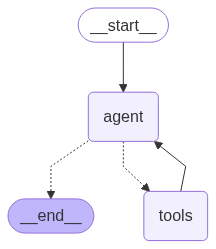

In [59]:
# Visualize the graph
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

Image(
    create_agent(context).get_graph().draw_mermaid_png(
        draw_method=MermaidDrawMethod.API,
    )
)


## Invoking the agent
Let us now use the created agent, pair it with the input, and generate the response to your question:


In [60]:
agent = create_agent(context)

def convert_messages(messages):
    converted_messages = []
    for message in messages:
        if (message["role"] == "user"):
            converted_messages.append(HumanMessage(content=message["content"]))
        elif (message["role"] == "assistant"):
            converted_messages.append(AIMessage(content=message["content"]))
    return converted_messages

question = input("Question: ")

messages = [{
    "role": "user",
    "content": question
}]

generated_response = agent.invoke(
    { "messages": convert_messages(messages) },
    { "configurable": { "thread_id": "42" } }
)

print_full_response = False

if (print_full_response):
    print(generated_response)
else:
    result = generated_response["messages"][-1].content
    print(f"Agent: {result}")


Question: Hi
Agent: I'm happy to help! Is there something specific you'd like to know or discuss?


# Next steps
You successfully completed this notebook! You learned how to use
watsonx.ai inferencing SDK to generate response from the foundation model
based on the provided input, model id and model parameters. Check out the
official watsonx.ai site for more samples, tutorials, documentation, how-tos, and blog posts.

<a id="copyrights"></a>
### Copyrights

Licensed Materials - Copyright © 2024 IBM. This notebook and its source code are released under the terms of the ILAN License.
Use, duplication disclosure restricted by GSA ADP Schedule Contract with IBM Corp.

**Note:** The auto-generated notebooks are subject to the International License Agreement for Non-Warranted Programs (or equivalent) and License Information document for watsonx.ai Auto-generated Notebook (License Terms), such agreements located in the link below. Specifically, the Source Components and Sample Materials clause included in the License Information document for watsonx.ai Studio Auto-generated Notebook applies to the auto-generated notebooks.  

By downloading, copying, accessing, or otherwise using the materials, you agree to the <a href="https://www14.software.ibm.com/cgi-bin/weblap/lap.pl?li_formnum=L-AMCU-BYC7LF" target="_blank">License Terms</a>  